In [1]:
from IPython.display import Image
%matplotlib inline

Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length, and the fourth column the petal width of the flower samples. The classes are already converted to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
#X = iris.data
y = iris.target

Splitting data into 70% training and 30% test data:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

Standardizing the features:

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Training a perceptron model via scikit-learn

Redefining the `plot_decision_region` function from chapter 2:

In [5]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=42)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
y_test_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_test_pred).sum())

Misclassified samples: 2


In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[14,  1,  0],
       [ 1, 14,  0],
       [ 0,  0, 15]])

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy score: ", accuracy_score(y_test, y_test_pred))
print("Precision score: ", precision_score(y_test, y_test_pred, average=None))
print("Recall score: ", recall_score(y_test, y_test_pred, average=None))

Accuracy score:  0.9555555555555556
Precision score:  [0.93333333 0.93333333 1.        ]
Recall score:  [0.93333333 0.93333333 1.        ]


## Visualize the Model 

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

Graph the perceptron model

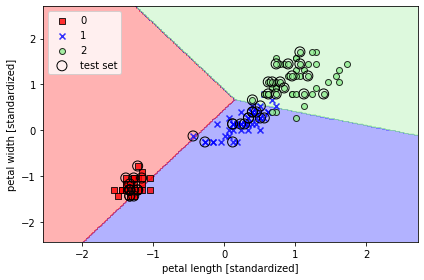

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

# Modeling class probabilities via logistic regression

### Logistic regression intuition and the cost function

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAagAAAEYCAYAAAAJeGK1AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsnXd8zdf/x5+fe7NlChESScSsmRpRI/YISm0StJRflbZKa1RVVdESo61VlKpWzSBGiNgjpVbt8UVkkYiELNn3fn5/3CQSGUJu9nk+HvdxfT6fM973Iq+cc17nfSRZlhEIBAKBoKShKO4ABAKBQCDICSFQAoFAICiRCIESCAQCQYlECJRAIBAISiRCoAQCgUBQIhECJRAIBIISiRAogUAgEJRIhEAJBAKBoEQiBEogEAgEJRKd4g7gdahkaio7VKlS3GG8kuiwBBKslCApsDAzLu5wBAKBoERx/dL1CFmWK7+qXKkSKIcqVbiwZElxh5Fv5uyJQr9bPBWbVKeTQ73iDkcgEAhKBDX1awbmp5yY4itEZvYxZ6rnUZ5eCcZz9yHCUsOKOySBQCAoNQiBKmyGD2eqQTWSfI047X0Nz4u3izsigUAgKBUIgSoi0kdThGhGU7eThFAJBAJBXpSqNaicSFEoCLG0JFFXt7hDeTVTp9IbiIoC6a7Mc4Pnhd6lQl+BflV9FDridxGBQFC6KPUCFWJpiUnVqjiYmiJJUnGHkz8iIwmzMAWFhIWpSaF1I8syz54+42noUwyrGxZaPwKBQFAYlPpfqxN1dbEsTeIEYGmJtUIXOVHmWVQMMcmJhdKNJElYVLRAnaQulPYFAoGgMCn1AgWULnHKRFUDXQzCU1HFJ/MsJpYUOUXrfZTW70YgEAhK/RRfacfcWjP19ihKRZw6AfRUWBgZFHNUAoFAUPyUiRFUScDn8GHqtmhBraZNmf/TT69dv5q5EutnMZCczLOomEIZTQkEAkFpolyNoDp16kTMkyfZ7ptWrszRo0ffuF2VSsUnU6ZwaNcubKtVo0WnTvTp0YP69V4ze4SlJdbAwxA1cYjRlEAgKN+UK4GKefKEC5UqZbvfPAfReh3OXbxILUdHHB0cABjavz+79+9/fYFKw8ZWAc8TCAOegRApgUBQLhFTfFrgYWgo1W1sMq5tq1XjYWhowRqtUAGD8FRITi40l59AIBCUZIRAaQFZlrPd04Z7ztzaMIvLTyAQCMoTQqC0gG21agQ/fJhxHfLoEdWsrbXStrm1IdYKXdRRUqHumRIIBIKShhAoLdCiaVPu3r/Pg8BAkpOT2bJzJ3169NBqH+kuP1W8cPkJBILyQbkySZhWrpyjIcK08ivPzcoTHR0dlnt40H3AAFQqFR8OG0aDt94qUJs5kubyexSlEi4/gUBQ5ilXAlUQK/mr6NmtGz27dSu09jNTzVwJkVGEWZjyLDkZQzM9DCQhVAKBoGwhpvhKK2n5/FSPlCREC6efQCAoewiBKuXY2CpQPVKiShRrUgKBoGwhBKoMYGOrKPTM6AKBQFDUCIEqIxRFZnSBQCAoSsqVSaKsIzKjCwSCsoQYQZVBXs6MrpJVxR2SQCAQvDblTqBezkqUQ5ai1+bDTz/FqnZtGrZqVfDGtEUml19iQjKeF28Xd0QCgUDwWpQrgVrzhx5LVuhniJIsw5IV+qz5Q69A7Y50c8PH01MLEWofG1sFZikqCAnGc/chbicJoRIIBKWDciNQsgyxcRKbd+hmiNSSFfps3qFLbJxUoJFUuzZtqGhhob1gtY2eHlMNqhE7y5LrPsFiNCUQCEoFxWaSkCSpOvAnYA2ogTWyLP9SeP3BF58kAbB5hy6bd+gC4DYghS8+SUILycdLPHMW6MPGo3i49wDe7KwqgUAgKCqKcwSVCnwpy/JbwDvAJ5Ik1S/MDjOLVDrlRZwyGD6cpH1KPHcf4miAGEkJBIKSS7EJlCzLobIsX0r7cyxwC7DJu1ZB+9RM62Um85pUeWFmH3Omeh7l6RXNulRYalhxhyQQCATZKBFrUJIkOQBvA/8WVh+Z15zcBqRw/mgcbgNSsqxJlSuGD2eqQTWSfI047X1NrEsJBIISR7ELlCRJxsAOYKIsyzE5PP9IkqQLkiRdeBIdXYB+wMRYzrLm9MUnSbgNSMHEWC7QNJ/b6NG06taNO/fuYdugAev++uvNGyti0kdTwuUnEAhKGlJOx5UXWeeSpAvsAw7KsrzkVeWb164tX1iStditatV4q2bNfPcpy2QRo5evyyK37t/nrUePXllu5rQkTGZHgpkZAzs4F0FkAoGgPFJTv+ZFWZabv6pcsY2gJEmSgHXArfyIk/b6zfu6PDNngT5Tr4ZAdLQYTQkEgmKnOKf42gAjgE6SJF1Oe/UsxngEAM7OTDWoxltLo7h+vbiDEQgE5Zli2wcly/JpQIxfSjIhwXiGh9O2ax2sdayLOxqBQFDOKHaThKBk0ntqfY3Lb59SuPwEAkGxIARKkCcvu/zEnimBQFBUiPOgBK9m+HCmonH5neYa2EYxsJlIlSQoPFJSUji05xB7tuzhWeQzLCwt6D2kN137dEVPr2DJnQWlBzGC0gLBISF07N2bt1q2pEGrVvyyalVxh1QoZLj8xJ4pQSHy4O4DXJ1c+evXv+jetztfzv4S136u/L36b1ydXHnwvwfFHaKgiCh3Iyifw4dZsXEdAcFBOFS345Pho3Ht0qVAbero6LB47lyaNmlCbGwszTp2pGuHDtSvVwZHGc7OGaOp6wRz3SxG7JkSaI2op1GM7DWSsZPH4v6Re5Znfd37snntZj549wN2n9mNhWUJPkFAoBXKlUD5HD7MnHWL6TmlB0MaDSXwWiBzFi4GKJBIVbW2pqq1xuVmYmLCW3Xq8DA0tGwKVBpzFujDuRB+tNDhqMNtOjmU3c8qKDq2/r6V5m2bZ4jTCd8TbFq/iZDAEGztbXEf5Y6zizPb1m9j7OSxWeq+XLZRk0Zcu3ItS9323doXx8cSvCHlaopvxcZ19JzSA8e3HVHqKHF825GeU3qwYuM6rfUREBTEf1ev0rJZM621WWJxdiZ+rRlPrwSLzOgCrbBt/TZGfDwC0AjOqpWraP1ZayYfnEzrz1qzauUqGr7dkK2/b81S7+WyTqOc2Om1E6uWVlnqnvA9URwfS/CGlCuBCggOwr6RfZZ79o3sCQgO0kr7cXFxDHj/fX7+8UdMTU210mZJZ84CfZEZXaA1QgJCqO+kOXVn0/pNuE51pcbbNVDqKKnxdg1cp7rid8qP4AfBZE7T9nJZYxtj+s7ty50zd7LU3bR+U3F9NMEbUK4EyqG6HYHXArPcC7wWiEN1uwK3nZKSwoAPPmDYoEH07927wO2VKkRmdIGWMDAyICZKkzM6JDAEu0ZZ/2/aNbIj6EEQhkaGSJnylL1cNjk5GYfmDkQGRWapGxIYUsifQKBNypVAfTJ8NPsXHsD/P39UqSr8//Nn/8IDfDJ8dIHalWWZ0Z99xlt16vDFJ59oKdrSh8iMLigonXp2Yu/WvQDY2tsSdC3r7EbQtSAUsoKOPTtmuf9yWT09PQIuBGBpZ5mlrq29bSFGL9A25UqgXLt0YeboLzm79AwLXD04u/QMM0d/WWAXn9/Zs/y1dStHT57EycUFJxcX9vv6ainqUkbaaCp2liXXfYLxPH6uuCMSlCJGjBvB2p/XEh4ajvsod3w8fHjw3wNUqSoe/PeAPXP2EPEoghHjRmSp93LZuIdxeH3jRd1WdTPq+nj44D7KPZeeBSWRYj1u43XRxnEb5ZH8Hrehdc6dw6Ox5jfWhq7VqacvnH5ljZxcdgVxyi2fv5x1y9YR9ywOC2sLXDq4EJcQR3BAMAZ6BoQGhjJi3AjGTxv/yliEi6/kkt/jNsqVzVxQxKTtmdrrcZPrAK4IkSpDpDvnXKe6ataGrgWxykOzSf1NhGD5/OXs9NrJqA2jiHkcwwGPA+zZuodKVpWQ1TI2djZ8u+RbevTvkWP99t3aCwEqYwiBEhQ6vafW5/KeKK7rhWPe1VxkRi8jZHbOAS+ccss2vZFQbN+0nQFLBlCrVS0AmvZtysVdF9k/ez/bDm7DzrHgZiZB6UIIlKBImNnHnDl7ojidLHL5lQXUajW3rtwibF4YAf8FAFCzeU3aj2xPcEBwtvLxz+Px2uTFtvXbCPIPwsDQgA6uHRj+8XDqN9HYyuNi4nBo7gBAdGg0fhv8uOB5gYjgCEa+O5I+Q/swdPRQrG3ELzjlhVxNEpIk9c/HSxwwKMg3IjN62SA5OZnxQ8YTExFDrRa1mHtmLnP/mUuz3s3Y8vUWosKjSElJySgfGhJKv9b9OOFzgsnfT+bIjSNsObIFWwdbPuzzIeuXrgfA2NSYgAsB3PW7y/z284mLjKPLxC5UrVmV5ZuXExUZRe+WvTl74mxxfXRBEZPXCOo3YDd5HyrYDtiv1YgKmZiYGO76+6NQKKhXuzaGhobFHVL5QmRGL/XMmzwPWZZZvH4xa39by9OHT7FrZIdtA1vsatuRGJHIwm8W8vWCr1GpVPxfv/+j77C+jJs6LqMNC0sLxk8bT1/3vrh1dsPG3oZB7oPYNnUbT0OeMnLtSPSM9PD6xoshI4ZQv0l9vvvlO7r3685nwz7Dy88LG3ubYvwWBEVBri4+SZI2yrI8PM/K+SijTQri4nv46BHfe3iwzcsL++rVUavVPAoL4/2hQ/lm8mQqWpTdxJPF5uJ7FcLlV+qICI+gS8MuHL99HPOK5iyfv5ztm7YTFxOHsakxLZxbEBEZgd9BP1x6uGBuZs4x72NUdaxKdYfqOTrrkhOTWb1oNZ4nPRnSeQi3b9xGx0Ano73Y57FZyvsd8UOhUNCqY6s8HYTadhi+LsXdf0kmvy6+XKf48iM8RSlOBcE/IIB3unbFwtycm2fPcvnUKa76+XH+6FHi4+Np4+pK+JMnb9R2VHQ0K9eufePYfv71V+Lj49+4fjrHT5/mn3//LXA7RYqzs9gzVcrw2elD516dMa9ozgnfE/id9ePDVR+y6Noihi4ayqXrl6jevjpOPZwwqGnAIe9D1OtUjym+U7BqacVOr504jXLKkh9PqavkYdBDAu4FEOwfzM7jO7kYcJHvF33Pw4iH2XLxOdZ1ZNv6bTnm6UvPtZdbHr+iysVX3P2XFd54Daoogywowz/6iCkTJjD/u+8yso4D1LC3Z9VPP/Fejx6M+/LLN2o7KjqalevePNnsz7/+SnxCwhvXT+f46dP8c650/oBPP2dKdf25WJsq4USER1C9RnUg7/x3VRyrkKpOpaJdRZ49foZSR8mdM3foO7cvxjbGWfLjbf1zKzZ2NkSERxDxOILqjjm3n17+yMEjRD+LpvuU7tmepefay61uUeXiK+7+ywp5ZZLonfYaDawDhqW91gKlYuQEcOG//wh9/JhPxozJtcw3kydz/PRpgkNeP0/XV999x/2AAJxcXJgycyYAC5cupUWnTjRu04ZZP/4IwPPnz+k1eDBN2ralYatWbN25k6WrV/MoLIyOvXvTMYf8fV999x3133mHxm3aMDmt7ScREQx4/31adOpEi06d8Dt7loCgIFatX89Pv/6Kk4sLp/7557U/R7Hj7Mz02laognW4GRJV3NEIcsHM3IzHoY+BvPPfPQt9hl4FPSpWr8izkGcARAZF4tDcgeTk5Iw6do3sCA4I5nHoY8wtzDGraEb4o/Ac208vH3gvEKVSiX1j+2zP0nPt5Va3qHLxFXf/ZYW8pvhGybI8CpCB+rIsD5BleQDQoMii0wLevr4M6dcPpVKZaxljY2N6deuGz5Ejr93+/O++o6aDA5dPnWLhnDn4Hj3KXX9/zh05wuVTp7h4+TIn/fzwOXKEalWrcuX0aa6fOYNr585MGDuWatbWHNu7l2N792Zp9+mzZ+zy9ubGmTNc9fPjm8mTAfj8q6+YNG4c548eZceGDYz5/HMc7Oz4eNQoJo0bx+VTp3Bp3fq1P0dJYfq/viIzegmme7/uHNx1kOdxz3PNf2dmbcZV36s06NIAm0Y2JD1PAsDSzpKACwFZjmwPuhZEBaMKmJiaULNeTXoN7IXnn55A7rn41KlqqtpXzfFZeq693OoWVS6+4u6/rJCfXHwOsiyHZrp+DNQppHi0Tnx8POZmZq8sZ2ZqqpWpNt9jx/A9epS327Wjafv23L57l7v+/jSqX5/Dx48zbdYsTv3zD2aviMnUxAQDfX3GTJjAzr17MUpzGx4+cYJPp07FycWFPu7uxMTGEhsbW+C4SwwiM3qJplr1arTr1o55U+Yx9IOh2fLf7Zqxi+jQaJq+2xQS4MaBG6jVak5uPEndVnXx+saLuIdxGfnx9s3bR3hIOB9+/iGSJFGvUT1WLVpFZ6fORD6OZNfsXRnt3zh1g3Xj1xF4NxATM5Msz17OtZdTHj9t5+I74XuCsW5j6dW6F2PdxmZZXyqK/ssD+dmoe1ySpIPAZjSjqaHAsUKNSovUsLfn2OnTryx3+do1unXs+Mpyr0KWZaZPmsTYUaOyPbt4/Dj7fX2Z/v33dOvUiW+nTs21HR0dHc4dOcKREyfYsnMny3/7jaN79qBWqznj61vm7fEz+5jDxn14DOyEZ0iwcPmVIOaumMuo3qMIDQmlfbv2+C31Y2vgVowMjZCjZaLjotFDj8vrLzOg/wDOnDrDX5P+wtrWmk49O3F5/WX2fLsHHYUOkWGR9B7cmwEjBnDC9wS79+6m7/S++Cz3oUbrGgReDMR7tjePHz0mKjKK1KRUPlrzEVaOVmyZugXv2d48j9WM5j4e/3GGSy79fdOyTWwL3JbteUF5VZqnwu6/vJCvZLGSJPVDs+cJ4KQsy7sKNapceBObeVR0NDWaNOHGmTNUq1o1xzJXrl2j55AhBFy5gq6u7mvFFPn0KU3btyfw2jUAfI8eZeYPP3DEywtjY2MePnqErq4uqampVLSwwMDAAC9vb/7YtAmvv/+mUevW7Nm8mRr2WefT4+LiiE9IwKpyZZ4+e0atpk15+uAB7mPG8HbjxkyZMAHQCKtTo0YsXr6cmNhYZk+fni3GEmszzyczpyVhMjsSzMwY2MG5uMMRAEmJSXhu8OTvNX/jf8cfWZap06AO7h+5M+D9AVmm8QCehD1h4+qNbP19K9HPolGr1LTt0pYR40bQwbUDAGPdxtL6s9bUeLsGwTeCObz6MGe2nUGVrAIJmnRvQr+v+1G9ocZE8eC/B/yz7B9Wb15d1B8/S6zpFGc8pY382szzK1D2QG1Zlg9LkmQEKGVZLvJ5pTfdBzV7wQIOHD7M/m3bsu13Cnn4kC79+vHF+PF8NHLkG8XlPmYMV2/coEeXLiycM4dfVq1i7Z9/Apr1rY2rV3PP358p336LQqFAV1eXXxcvpvnbb7NszRpWrF1L1SpVsqxDhYaF8d6wYSQmJiLLMpM/+4wP3NyIiIzkkylTuHXnDqkqFe1atWLVTz/xv3v3GPjBBygUCpYtWJBlHaq0CxQg9kyVYJKSkpAkKZso5YQsyyQlJqGrp4tSqSQpKYmoyCiMjI0Y6jqUyQcno9R5sV6cmpLKwq4LkRQSU3ynZHmmSlWxoMsCNuzagLmlOfr6+oXy+XKiV+te2WJVpapY1H0R3v94F1kcpRWtCZQkSf8HfARUlGW5piRJtYFVsix31k6o+edNBUqtVjN11iz+2rqVD4cNo0uHDqjVavYdPMjGbduY9vnnTP3888IMvVgpEwKVxl6Pm9yaYC5GU6Wc+7fvs/aXtez33I+BoQHPY59jUMGAbhO64fqZa0a59FEJkGXE8t/+/9izcA9BV4OoWKkiifGJ9BzYk9Gfj6bWW7UKPX4xgioYBd6om4lPgDZADIAsy3cBq4KFV7QoFAoWzZnDSW9vkpKTmbtoEfN//hkTY2P+O3GiTItTWaP31PpMNaiWsWdKnNpb+jh74ixDOw/Fxs6GI9eP8G/Qv1x6fInBIweze/5u1o5fm81YkNl0sH32djZO3YhSreTX7b/yb9C/HLlxBBt7G9y6uPHPscLfZiFMEEVDfkZQ/8qy3FKSpP9kWX5bkiQd4JIsy42LJsQXiAML34yyNILKzJw9Ueh/aCly+ZUi9u/czxcjv8Dazpq6jepmS32kr6PPQa+D6BnpUbFKxSypjgwNDImOiibkXgjvdHmHZs7NsqVN0tfX5zP3z/C96ouFpXbTl4kDEbWHNkdQJyRJ+howlCSpK7Ad2PuKOkVKaToVuKgpy9/NzJh9IjN6KeKE7wkWzl5IPZd6zDozK1vqI6dRTly/e51WQ1pRrW61jNRJVi2tmHxwMr3n9ib8UThjJo1h5Mcj8Tvrly2VUFJSEu26tWPHnzu0HvvLqYv8zvrhPsod73+8Wb15tRCnQiA/AvUV8AS4BowF9suyPKNQo3oNDFJSiIyJKdM/iN8UWZaJjInBINPRB2WKtD1TsbMsxZ6pUsCm9ZuQdWS6f9I9x9RH6amSnkc/J/ROKLK+nJE6SamjxNLWkpTkFG7fvp1nKqH+w/vj4+Wj9dhF6qKiJz/7oIYBW2RZ/i39hiRJ78qyvK/wwso/tpGRhKBJASTIjkFKCraRkcUdRqEyZ4E+nAvBA8SeKS2TkpJC4L1AUlNTsbG3QU9fj8D7gchqmeo1qmNUwShL+edxzwkJCEGhVGBf0z6Lsy8kMAS1So1JJRPgReqjJw80iZrTUyXtnrmbChUrEBcVR7329dg9czcACbEJmFQy4VGwZro6p1RC2wK3UalKJeJi4rT6PeSWumhb4Dat9iPISn4EahnwpSRJbrIs30q79z1QIgRKV62mxhtmIheUIZydM86Zuk4w181ihMuvACTEJ7D2p7VsXrsZfQN9dHR1CAkIQZIkrKytMDA0IDwsnD5D+jBu2jhUKhUr56/E29ObKlWrkJKSwvO45wweNZixk8dSwbgCtva2PAh+QNi9MOwa2WWkPrKoqlkrSk+VZF7VnMf3HmNexZyACwFY2lkCYFrJlJgnMTRs3BAdXR2CrgVlcdGlpxLy/58/VapW0er3kZ66KKf+BIVHfqb4HgAfAp6SJA1Ku5fXIYYCQbHxcmb0owFi2u91iX8ez/s93+fW1Vv8vud3dvntQldXl669uzJo5CASExP55e9f8L7gjZ6BHn1b96Vfm36YWZjh858PPpd9OHLjCH/5/EWQfxDuXd2JjYnVONyS4cDSA6hSVdlSH8U9jMPrGy90dHWo36E+qhgVXt94UbdVXVSpKsLuh2FsaoxNNZs8XXSb1mxiwPsDtPqdCNde8ZAfF98lWZabSpJUCU26oytAt5Li4hMIciNjz5SePgN7tHt1BQEAsyfNJiYqhkW/L+LkoZNMHzed5ORkmrZpSmOnxvju9eXutbu49HShUZNGrJy/Elkt0/7d9tmcbW4j3Ti0+xAqlYr5q+dzxPsIkz6YhJGpEU1aNslWvopVFbav307VGlWpXb92tuet2rZixY8rWL93PZFPIrMdCHjv5j22rNvCvgv7Xnvj7qsOGBQuPu2RXxdffqb4QgFkWY6QJKk7sABoWMD4BIJCp/fU+vQGfrwbTlhqGNY61q+sU96JjYll9+bdHLh0gJOHTrJ0yVKio6JZeG0hZ7adYeeWnQycPZDYGbGYNzFn89+b0TfWR89QD6WNkp1eOxn0/SCGthpK0LUgVnusZtiwYcz8dCbTfphG516dOXDxAKN6jyIpNol6DerRe1BvnkU+w+tvL/Zt38fPf/5M977dc42xmm01RvYaSa+BvRg3aRwWlhbcvXmXP5b9QfCDYP7Y98cbiVNeufXS39P/nJ/ygoKTr1RHhda5JP0OvAuEy7L8StETIyjBmzBnTxT63eLBtrrYM/UKjuw7wp8r/2TD/g2MdRuLYU1Dwh+E8/Haj1k+cjlt/68tFlUtuOV9C/+r/qjVakJvhOLUw4n/9v/H4CWDsahqgb2jJrdkRiaIFHh38Lv0Hqw59ywxIRFvT288N3gSGhyKkbERXft0ZejooVS1zTlnZmZCQ0LZ+vtWDu05xPPY51StXpUB7w/g3UHvYmBo8Nqf+3UzQ4hMEgWjwCMoSZJ+lmV5oiRJe9FkMc+CLMt9ChgjwB/AcuBPLbQlEOSIyIyef+Lj4zG1MAU0zrWmzk15/uw5kNV1Z2RuROLzREyrmJIYl0gF8wo8f/Y8iysPoIJ5Be5cu4OjoyPRT6Mz7hsYGjBgxAAGjHiztaKqtlWZ+O1EJn47sQCf9gWv69ITrr6iIa8pvr/S3hcVVueyLJ+UJMmhsNoXCDIYPly4/PKBrb0td67dQZZlbO1tUalUBN8IBsjiugu5EUJF24qoUlUolAqCbwRjZm2W8TzgcgA75+3k3r/3MNA34Nypc1z45wIB9wKYOGsixibGxfxJs/K6Lj3h6isa8jpR92La+4mcXkUXokCgPdJdfkRHi1x+OeDk7IRCoeDM8TO4j3Ln/sn7hN0NI+BKQIbr7um9p5zZdoY6znUIOBdA1OMorvhcwbmfM17feHHT5yaLByzGvrE9Dd5pwPhp46lkVQnv897ERMdkuPpKEq/r0hOuvqIh1zUoSZKukcPUXjracvGljaD25bYGJUnSR2iyqWNXuXKzwHXrtNGtQCAyo+eCzy4ffpj2A38d+IuA+wF4zPTA/7Y/LTu2xMLcAt89vqjVaqzsrDDSN+Lu9bsAmFubU7duXS79c4kqdlWo26gu9vb2bFqzCfPK5jRo2gC3kW747PTBwMCA7375rlA/x6tceUVdXvCCAh+3kXYGFGiymcOLKb9hQLwsy98XOEpeLVCZESYJQWHw491wlNVTqdikOp0cxNoUwKbfNrFo5iJ6D+5Nt77d2O+5n50bd5KqSsWusR0DZw7E+xdv7py+Q71O9TC2NObmoZuoUlSYVDBhyfol/LHiD44dOEbn/+vM4O8HE3QtCB8PHwYPHsz3k77n1L1ThTbVl5PLzsfDR5xqW0LQ5nlQfrIst3nVvTdFCJSgJLDX4ya3Jlehbdc6wo6eRmhIKFvWbeHfk/+SmpLKw+CHVGlYhcSYRNRqNU9Dn+I61ZVabWph5WBF8NVg1rivIfZJLG87v03Ekwj6zO7D2z3ezmgz3ekWGxHLuKnjcOnqUiixC5ddyUab+6A7StsBAAAgAElEQVQqSJLUVpbl0wCSJLUGKhQ0wLS2NgMdgEqSJIUAs2RZFnN4giKnd4c4rt+vxOnka7TthRApNE65YR8No27DuqSmpPLL/F/4fNPnGafIfuPyDXbN7Li676rGWt7MHofmDvzv5P/YenQrvVr3onHXrCsB6U63qlZVSU5Kfq14EhMSOXPsDNFR0VS2rkzLdi3R0cn5R1h+XHZB/kFcvXgVWZZp6NSQGnVqvNyMoJjJj0B9CKyXJMkMzZpUdNq9AiPLsps22hEICoyzM9PRuPxOcw1so8r1nqnHjx4zd8pcTh8+jbOLM/oG+oQFhDGr3SxGLByBkbkRUY+iWNpzKQ4tHNA31MfzK0+UukpQa9rIzelWrXo1bpy7gUMth3zFkpKSwtK5S9mydgu1G9TGytqKwPuBhIeF8/Hkjxn+8XAkKWv2tbxcdv53/Jk7ZS7XLl6jZbuWSJLE3MlzqdugLl97fE29RuX3772kkadASZKkAGrJstxEkiRTNFOC0XnVEQhKM+U9M7osQ3joY4Z0HEIftz7MW/kDpmaa7OPHDhxj/nfz+XnIz0gKiXrt6hEeEE6HsR2o41KHe373+Gv8X8THxPPfuf9wH+XOKo/s60BNGzUlNiKWmvVefdCoSqViwrAJJCYksuPUDuwcX4yKbl65ybT/m8aj4EdM+2Falnq59d373d64dXXj4ykfs3LryoxNvUlJSez8aycjeoxg/d71NHxbJMspCeRnDeqkLMslIpGZWIMSFCUzpyVhMjuy3Lj8Nq81wXfPT5z/52fUsprKNpVRqh1JSHlAclIsxqbGNG/RnIO7DpKYkEjH3h1JjEvk9p3bpCSnoKunS/uO7XkU+Igbl2/g5+/HxTMXszjd3mnzDr8u+JVlfy+jZbuWLJ+/nO2bthMXE4exqXGWE3Rt7W2xt7Pn0tlLbDq0iTPHz2RzzTVp3oTeLXuzdONSYqJjXpkrb/kPy+k/vD9uY9xydOFFP4tmlccqvC94ZxuVCbSHNk0SM4EEYCvwPP2+LMtPCxrk6yIESlDknDvHjxYOZd7lJ8vw4XtruRv0F0+DnjDr8iz2zN5L8NUg+n7fn1qtHAm4EMCWiVtIeprEW43eolGzRly+eTnbKOXDMR/yxftfoKOrg9sYN5ycnUhMSOTAzgOcO3UOj9886PxuZ5bPX85Or530ndsXh+YOnFh9ggueF+g3sx9NOjYh6FoQi/suZvSE0Tg5O+Xqyrt74y7HfY6jMlTl6dq7dfUWY/qN4cSdE/gd9cuxvbHjxjJv8jx++PUHWrRtUcx/K2UXbQrUgxxuy7IsO75pcG+KEChBcVEeMqO3b9yeRv2aEHgxkFEbPmZhhzkMXjwI+6b2GVNhmyZu4trea0yeNZnffv6N0etH5+iUq2pVlQqmFVCr1Ny/fR9dPV3adG7De27vUcG4QkZ/A5YMoFarWgCsG7UOlzEuVKhYgboN6pKckMx4u/F0eLcDkiTl6sqbMW8Grk1dmbZ/Wp6uvfXL1hNwN4DZS2fn6fKr6VgTwwqGfPb1Z4X3ZZdztObik2VZWFsE5Z7MmdE9j58rNVN+UU+jOLzvMDHPYrC0sqTzu51z3XsUFxNH5RqWPLyuObE2KTYRhxYOqFXqjDKmVUxJSUlB30CfuNi4XJ1y9nb2mJmb8dGXH+UaW1xMHA7NHTKunwY/xb6FPeH/CwdAlaJCR0+Hh0EPM9rOqS99A31SU1Jf6dpLTUlFT19zwm9eLr/69eujSlXlGreg6MjPgYVIktRQkqTBkiS9n/4q7MAEgpLI9H99NWmSLpbsFElJiUl89/l3dKjXgWP7jxESGIL3dm/a1W7Hwm8Wkpqamq2OsakxqSlqAi9q0vfomxgQcD4AKdP5pEodJbJK5rzfeayqWRF0LShLG+lOuQt+F6hdv3aeMRqbGhNwISDjumL1igSeD0Sh1PxYMjAxQL+CPqZmphmuvJz6Ou93HrOKZrk+T6dOgzqc9zsPkHd7p89Tp0GdPGMXFA2vFChJkmahOfZ9GdAR8AC0kclcICh9DB/OVM+jEBJcYnP5paSk8PGgj4kIj+Dw9cOs2LKCb5d8y5qda/C+4M31S9eZMnoKmaf3ZRkcHUZwcs0pjCyMuOF9AUdnR3bN2EXA+SBSU1K5d+Ye1/dfR6lQcnDXQT6d9ikHcshH16JlCyLCI2jXLe+p0EHug/D6xot7Z+6RmpKKQzMHds3YxfNHz1Glqgi4HICpmSlKWZlr7ruh7w/lj2V/MPTDoa/Mjde2S1uiIqO44Hch1/batm/Lvdv36NK7S6H9/QjyT37WoK4BTYD/0uzmVYC1siz3LooAMyPWoAQliZLq8vP805Ptf2znb9+/8Tvql82p1tKlJf3a9GPq3Kl07Nkxo166i+/WrbVEhERgWc2SCob1M1x8evom1LB/j6D7O4iLjWP7CU/WL43ixs3fSU0JxNbelrYd2rJqwSq+WfQNPfr3eGWsr3LxvTfoPZZ8u4T+I/rzVpO32LJhS8azwcMHc2jPIYIeBPHn/j9z/KwvpzU6uPsgsyfOZq3XWp48fpKlfMcuHVm5YCWTZk2i37B+Wv97EbxAmyaJc7IsO0uSdBHNCCoWuC7LcgPthJp/hEAJShznzuHR2BZsq1PRMuuj+rbmxZKRol+bfnz29WcodZW5Ot/CH4Vz0Osga73WZqkryyBJ4HfUj8kfTsahVg269+2Gvr4+W9Zd5eZVX1y6fIprf2NmT1qArq4LrTu60KpjPCcPnuC/f//j2yXf0meo9iZZwh6G8an7p0SGR9J/RP+Mjbo7/tpBs1bN8Fjr8Vo5/fZu28vsibNxcnaig2sHFAoFpw6f4t+T/zJ9/nQGjRyktdgFOaNNgVoJfA0MBb4E4oDLsiyP0kagr4MQKEFJZK/HTc51yLpRVM/RH/16OU//tW1SeMKlUql4y+Qtbsbc5JMRn+TqVJv3yzxcnVy58OhCrm2lpKTgu9uXs8fPkqpKpVa92jyP/YAj3nZpfcVh77gB84qadR0nZyfeHfwuhkaGWv9csixz5fwV9nvuJyY6hkpVKtHXrS+13qr1Ru0lxCewb9s+Lp+7rEl11LRhFoehoHDRpotvfNofV0mS5AOYyrJ8taABCgRlCedsM3yOEJF9J8Z1nX84fSUKiMpyv6IlWtljlf4Lp0KhyNOpplAoUKvV3Lp6iyPeR0iMT6SaXTXeHfQupuaaE3V1dXXpNbAXvQb2ytQ+HPHW/FmpNGb55r5IUt8Cx/0qJEnCydkJJ2cnrbRnaGTIoJGDxGiphJPXke9N83omy/KlwglJICi7NExtDRHZ71+P+gfPyNwNF22bmGe7l9MoTEdHh1pv1eLsibN55qPbt20farWaMX3H0GtQL8wszDhz/AwLv1nI++Pf5/OZn6NQZPVQyTKs+9ksy711P5sxemI0IumCoDDIawS1OO3dAGgOXAEkoDHwL9C2cEMTCMoPuQkXaEZdJ146w1ppHkVFyyjq22YXrmEfDeO3Jb/xwacfsMpjNT0yrUEd8PBhyODBTB87nV4DezF/zQJ0dV/8GAh7+JhP3T8hLiaOmYtnZtxPF6e924zpPTiO0ROjM66BDJFKX8MSCLRBrgIly3JHAEmStgAfybJ8Le26ITC5aMITCEo4GzcCuU42aIWGqa2z34zQjLpO3M96W2keRcMhDdm6cSvLPI5Q1WE0x5ZuJCwwDGt7a6pbjuPHaXOwsrbi7XdWsmG5XhZx2betDj0HbOO3JW0YMnoIdepr9gNJElQwUWeIkySBkbEaK+tUKhirM+qv+9mMCiZq3MZo/0h3cYJt+SM/x23USxcnAFmWr0uSpJ2JYIGgNHPuHHsfNYUOHV9dthDISbjO7Yfrjv70GfE3vy/4lqv/fI1Njfeo08SZ/90O5PTtiUhSPCvOLueCbxQnPKsRq1Yw8Qt1phESDB41hE2rN2U5lt1tTGzGCEmWIT5OweNQHZ7HKbKNsLQ9ksrphNxVHqsAhEiVYfIjULckSVoLbERzHtRw4FahRiUQlBaq2eTkkCg2NKE4QiV4Z8Vu/vrrAceObefi0aeoVK1p2taNoLvTeHKtC3bWULvZM3b9aYHPdk399gP9aTPuATfPVuf3mYcISw3LstaVLjqSpJnWA9i7zThjqi/zCEubbFq/CdeprhnraTXeroHrVFc2LdskBKoMkx+BGgWMAz5Puz4J/FpoEQkEAq0gSWBjc4q4uO2o1dFIUkWqmb3D7ZhITm6ah6WlDe91fJ/L3mbEJyQBYGetz6Ud9Qi4E0P80wqcvqJZ63qZTg71MkQqXZyAQjNM5OeEXEHZIz8280Tgp7SXQCAoBQQEXOerr9qSkBCHvn5bdHWrk5Dgy969/wJgbFyRpKR4Jk5sjY5OF6ys1qJQGBFw2pG+feHy3dU0a9SR2P09eXk1yai1xnFoUREOra9BbFJixrPCcvXl5UgUlF1eKVCSJLUBvgPsM5cvjuM2BAJBdqfcy9eRkY/48svmWFi0wNLyCG3aRHH0aEsaNpzDw4cfERFhz969vzB0aATW1nNQKEZjYTGQRo32cfKkgvj4MA4f/h0PjzNYW0Nmt7laDYrU1vzrDYf+hRs3oEEDaNkSLkff4s8/qnE1JAkXtwdZYiroPq/cTsj9ePzHb9ymoOSTnym+dcAk4CIgctALBMWIjw8kJEDfvi/MCl5eYGgIrq6aMr/+Og4Tk0o8e3YCWVaQlPQzTZu6Ym8/iQsXQJJuo1ZXYdeudlhYnKZXrw34+jbHzs4XQ0M79u0bwnvvfcbmzbWIj4cZMzQipVbD1Kk+PE9dgb5BADpKB6pWa0lcyr9s3hWAVWUHGth9gr3alfqRb2WJO7d9XvkVrvR1pk3LNrEtcBu29rZZDiMUlE3yI1DRsiwfKPRIBILSxMaNaQ6+ojuWQZY14nTqlOa6b1+NOJ06BS4uL0ZSly4d4MMPl/HnnwoSE1PZtWsdv/xyki+/1IiMjk4lXF0/5cCBlcTH27Fjx7vY2FRiwYLhpKbq0Lz5Nwwc+Ak//ghXr8K8eRqRmjrVh1jlHHpO74lTuyHcu3SDXfPW0rJTB4YNH0LIzUAOLppDKysA1yyx57TP69w5oOf+XDcoV7Qkyz6vup3qsrrbaq19n4KST35y8c0HlMBOICn9fnFkkhC5+AQlho0b2VvnyyJ38KWPmNJFCjTilD6iSkyMZ/DgCnh5qVCpFLi7PyIpqSkQBoCODtjbQ0rKfYKCatO4cSChoQdITX1ATMwGhg0LYMAAPSRJI2bz5mlECkDXpDdDFr5Ds06a2f2wx/d49vgpp1f78X8rJgEQeNWfE4vO8vWXewv8Wa/r/JPtntI8ioYNwVyZdYNycSTlFbw5WsvFB7RMe8/cmAx0epPABALBmyNJGjHKLFDp4qRWq/H2Xg7A++9bY2RkgqvrQHbvTkbzX1Ziyxb46itQq2MBmc6dT/Hbb8dITQ1FlhNITv4BD4+bpKQkUq1aHT74YAxffpk+BReAU7shGf2mpCbh0MyB3SG7M+7Z1rcn/MkWrXzW3PZ5XYnKSbhu5yhc6QgBK53kx8VXPLsQBQJBNtJHUJnx8oImTa7y1VetUalSUSh0qFKlBlZWNdi9eymaiY9lwASGDtWMoCIjJwMK1q1bj6HhMGJjN6BWx7F9+wJq1GhIv36TefDgKhMndkCt7omOzirAgcsnAzNGULo6+gRcDMDStlJGLCE3A7Gq7FBon9/ZGchBuC7f9udKVFiOdTSjruxW+Xr6BU/OKyhc8jOCQpKkXkADNHn5AJBl+fvCCkogKE+8ypWX+X7mNaf0NahjxyL488+W1KvnzLx5x1i7dhK+vr8RGHgQ2IQmFdNEJKk7qal18fc/giwfoVKl0cTErKVKlf1ERJykTZt1PHzojlo9imPHNgJ7kKQZmJgMolmzsYSEfMJ+jzlAT5za2RMdGM/uebto2a8DqlSVZg1q8X7e6zgze/CFjFMlR0jN2Vh8bj9cvO2f5Z6OdRjX00ZdOWGuLJ6zvARZyc8a1CrACM1hhWuBgcA5WZZHF354WRFrUIISg5bWoPLjyntV+UmThhMaeojNm0P56ScFcXGpBAXV5MmTWHR0ttK4cQcuXzZDqTQhJWUOMB5z88pUrPiQkJBLpKZ2oHnzzjRtupvNm6Fy5RQSEhpSqdI6nj5tS/fu8Xh6OjJnzjGWLQvMcPFZVXagZvWW3A/+l/AnmuvuHT+hWdMcAs8nFy/5cPDYCq21lxeXI/xzvK9jHZaWjDf7M20ciSLQ7hpUa1mWG0uSdFWW5dmSJC1GY5gQCMolez1uAk2hgAa+/LryMuPqmvW+JMHDh7sYPPgbQEF8PFy/rkPDhnepUqU7169359IlUxQKQ1JSwoGxgES9eq25eLEFKSnhSJLEF19sZcoUiIkBU1Nduncfz4kTa9DTa4tKZUTXrmM4fPg3PDyWoFAUjmBcvOTD7uNz6D65J7b1Na7A3YvnABSKSDlVymUrZ6oj5/aT6wbll4WrWlUxXVhY5EegEtLe4yVJqgZEAjXyKC8QlF3OnYNqdWH48AI3lW54AI0opQtVZldebvUyk5QUT7t27igUGju4xnmnBxxDVzeKypV/oWHDR/j6rqFLlwMcPz6WBw/6UamSDSkpqURG/sAHH2hm721tQVcXDh50JiJiM+7umljOnXPG1/c3XjoiSqscPLaC7pN7Yt9YIxz2jR3p/mVPDi5aUWijqNzIcWCc2jpH4Xracz/Xyd0qL0Zdb05+BGqfJEnmwELgEho70NpCjUogKCe87MqLidnAwYM/sGXLIyRJQY0abzN69CJq1WqOWq3mypXDHD78O48fB6Cvb4S1teaH+Zw5vahYsRqtWw/giy+GMXKkJj+eQmHOypWziIt7iq/vGvr0qc7x40pMTDQC++GHfsyY8TwjnqVLYcoUkOU4JEk/k309Dl1d/UL9LsKfBGBbf0iWe9p0BWqDHIUromeOZfPa59WwoRh15Yf8CJSHLMtJwA5JkvahMUokvqKOQCDIB+lrTmp1HEFBDUlNfYiNTRc++GAiiYlxHDv2F1984Uzr1gOJigojISGGHj3G4eJize+/f0FAwFUkSQIkevb8hKNHN7BmzSwkaScKhcbtNm8eWFh8halpZS5erAfIJCaeR0+vBStWNEWWHyDL95GkmkyYoBlBxcVtw8jIFS8vjYCePr2N5s175flZCopVZQdCbgZmjKCg8F2BhYmzMzmK17lzcB0x6soP+RGoM6SdyJYmVEmSJF2isE9pEwhKKW/iyouIaE6FCgn07PmYs2crkpQE/fpB//5TOH/+EHPmdMPR8W1++ukSSUkpTJvmTMeO7zN06LesXz8dL68FpKQko1LtBA4gy3356Sc/1q+vzeXLIaSmbqBx4+mcPq3EyWk8KtVMnjzZx6NHhpiYjKJJk28ICNhESIiEldV11OoddOt2m1On4PHjf7h58zRffvl3oX5v3Tt+wu7Fc+j+ZU9s69sXqyuwMMlNuEAjXqrWOaeFKo8blHMVKEmSrAEbwFCSpLfRHPcOYIrG1ScQlD/+9z+gbq6PX8eVJ0ma+7Vrn+T+/f/xxx+PmDu3Ik+fgp6e5vnChXD2rBql0pqgoJssXgwXLniip1eJoUO/ZfFiiStX5mNgsJNFi4ZgaRmMQjERa+txLFu2CDOzZqSmTkJXtx6mpt/y9Ck0bTqRCxeOEh/fjwoVPGjceBYREV3R13fDzMyFZ8/m8tlnK2jVyoyQkA0cOzaFqVM3YmBQoVC/2vR1poOLVhD+ZAtWlR14r+PMIl9/Kk4y9nnlkBbq5Q3KSvMoIIq2Tcru5uS8RlDdgZGALbCYFwIVC3xduGEJBCWQ9Px7U3M2SLypK2/69Jk4ODTB1NSaxESNk27/fujWDc6fh5SUdSiV3yLLn3P+/HoSE/9Gkj4lJUXiyhWIjgZT0wukplYmImI6MI3gYGNkOQrQRVd3AEOH/s3NmwoeP4b//tNl+vTdzJv3A9eudeL2bRuqVjUhIMCblJQdWFvX4vDhdaxdO5EaNZowe/Zu6tVrVahfbTrNmrqWK0HKLzluUI7QWOVP5LpBOed9XqVp7Ss/+6AGyLK8o4jiyROxD0pQrORj79OrcuXlxEcf1aJhw3ZMmPA7KhVMmAAhIZlLtESh+AWVaiCSNADYi66uL5JUC1nWjMISEiAlpSFK5UZMTe8gy/eIivLA1PQaOjp2mKf9kl2xIjx9+iKW1q2TqV//PElJz7GycqBSpercu3eB5OREqlathbW1MOyWVnLa56VfTzN1mNsG5aISL23ug7KVJMkUzcjpNzRrT1/JsuxbwBgFgjJHXrnyckNPz4CYmEgAlEqNk65//xfP69c34s6dZ0ACkmSGrW0FQkOjkCRNu+vXw9ChMrIchUJhzLp1Q5g8OYWoqB+xsDBFqXzR/4wZMHnyi7Y1iWHbZImnQQOXAn4LgpJAjvu8Ihy5HOHPxRz8GenZNUrSPq/8CNSHsiz/IklSd8AKzRHw6wEhUALBS+SWKy8vkWrbdjCenvNRq9XIsoIJE7I+v3OnN6mpy4BnSNLHPH6cilr9NwpFc2QZRo0Ctfokmt8jNU68pKQ96Os3JTZWM3RKH0HNm5d1qvFVsQnKHq+7QTl9n1dxCFd+BCr9n25PYL0sy1ckSfxzFgheJrdceZnXpHL6nzNgwNds3TqXVas+5caNlYSEaDbM/vwzDBsGiYnvA1Owtq5JQkI1oqPHIknNmD9/DN9914Do6ESUyq8ZM+YzfHwkgoNj0NX9jlatvuXGDU0fLi5w/brm6IzGjTUjqd274eTJrLHl5jgUlA9y2+d17lxW4dJz9Odpvds8sszZKq8t8cqPQF2UJMkXTfaI6ZIkmQDqAvcMSJLkCvyC5ryptbIsz9dGuwJBcZDuysu85pSeKcLQMOcf/BrXnw6TJ2/Gw2MwSuVNdHVX0LNnA3R1wcHBk9u3Pwf0ef78GQYGK9HXH4G9/VJmz+6MickoYmKOY2joSI8e/8eZMwd5+HAaVlYdadBgIDVqwM2b8OABtGihiaFFC80JuYaGmjUpA4P85QEUlF+yC5cjRGhGXDmRW3aN192gnB+ThAJwAvxlWY6SJMkSsJFl+Wq+e8m5XSXwP6ArEAKcB9xkWb6ZWx1hkhAUF5r8e0CHjq9MEPum2ckdHY8zd+5YkpLuIkl6KBRq1GoV+vrt6dfPk2bN/Fm27EeCg49iZlYdtfoxz58/R6VSY2ZWC0mKQJKqoFBM5N1336dfPwkvL80oqV07jVjKskac0vvO/Ozl0Z8YSQm0yeUI/wyTxrTWvfJlkshVoCRJspZlOWf/4muUyaNuK+A7WZa7p11PB5Bl+cfc6giBEhQXez1uwtRpWm/3ZdefLIOxcQihoWdRKvUwNOxC+/ZGWabgtmx5wunTD5GkCujq1qJ588e8804YFSqYpp0BJeXLRfgmjkOBQBv06SPlS6DySv2Yy+Dttcvkhg0QnOk6JO1eFiRJ+kiSpAuSJF14Eh1dgO4EAoiMicFjxw7eGj8e48GDqfrBB4xbuZLrgYHFEk/macD069mzbTE1HUiFCn1QKIyyCIYkwdChldHXd0JPrzaSJOHubk3Nmk5YWzuiUEhZ2oPcBeflvvMqKxAUB3kJVBNJkmLyeMUCVQrQd07/DbIN52RZXiPLcnNZlptXNjMrQHeC8s6NoCCcJk7kRlAQ6ydM4NEff+C3YAHWFhZ0/uYb1h8+XOQxvez6k+UXTrt0vLxeXOfmEszv87z6zqusQFAc5GqSkGVZWch9hwDVM13bAo8KuU9BOeV5YiI9Z8/mhxEjGNGxY8a6kKmREbPc3Bjq0o6O38ygVtWquDRoUKixpPedLhAnTkD79vDee+lHZWR12qVPwb333ovrnFyCr3qeeXT0po5DgaAoydeR74XEeaC2JEk1gIfAUMC9GOMRlGE2nzxJkxo1GNGxI2t87IhN0OGLvv4ZQrHvvAtdGn/Kol27ClWgXs7V5+8PKSkaJ51CAc2bQ1iYxkmnUGR1AaY773JzCb7qeWbBeRPHoUBQ1BSbQMmynCpJ0qfAQTQ2899lWb5RXPEIyjYbjx/ny759kWWITdBh8ynNcucXff1Z4uXI5lM29H/nXebvWMizuDgsjI0z6mY4+ArIy7n63nsP4uMhPBwuXIDu3SExUXPcRc2aL0ZamUczOZ2o+zrPM/M6ZQWC4qA4R1DIsryfghktBIJ8ER4dTY0qVZAkjSgBbD5lkyFUbi4P+aJvGGsPmRIZE/NCoNJO0FW7u5OSFI+eniFvuk89pxN0ZVkznff06YsURO3bQ8+eiajVOiiVOtkEo6DXb1pWIChq8nWAsyRJSkmSqkmSZJf+KuzABAJtYmliwsNITb67zCKVzhd9/UlKSSYyNjbL6Oncw4csOruSQYOMcHeviLu7BatXf8ajR3ffKI6cXHszZmjeVaponj3z4MCBmri5mTJggAFffdWOU6e2olZrZW+8QFCqeKVASZL0GfAYOAR4p732FXJcAoFWGeriwu9pLj1ZhiVeWfORLfFyZLufH63q1sXS1BSA3w4epO/27dSycGTDhlB27Ehk6dJrGBmZM3Vqa65cOQLAy9rx8nVmV5wsw65dWa/nzYOUlEeEhLQkKekyzZptxtMzCU/PBPr0+ZwdOzz46acRqFSqbO0JBGWZ/IygPgfqyrLcQJblRmmvxoUdmECgTUZ07MipmzfxOns2Y83JzeUh5xefws3lIRuOykxYs4VJ72mGN//cusWszZtpUXUT18J/xMjIAgBLy+oEBMyhRg1PFi1y44cfQpk374UoqdUawVm8WHPt4/PCup0uTnv3gpUVLFqkSTV05YpMRMRABg4cRuPGmzh71hkvLwmlUpfo6AFYWJzm3r1QPD1/zHDf+fgUx7coEBQt+RGoYEDskBWUakyNjNgzYwYfr1zJ/os/0A8ivxsAABqsSURBVLnRKSa9d5+o53EolT8T9KQLXZ2G0b3p2wD8vGcPXw8chJpaXA2vmiFC6TZwPb32tGzZn+DgtVy9Srbn8fGgUr0wRaTvN/rf/zTvdeu+yItXs+ZZlMpwBg+eQd26L8rJssY8cf26IRYWK/H2Xs6OHUmcOqVpV4ykBGWdvFIdfZH2xwZozrj2BpLSn8uyXOQ5h0SqI0FBCYmIYOX+/fx++DBPYmLQVSrp9847fNrrXdrUfwuA5JQUzN3cCPvzT44tDWDeA3euPn2xZS99j9K9e+f45ZdRWFvf4GqmzJTpzzPnvMsrndBvv03CzKwSgwfPyDH1Ufohgw8ftqFixVl0795NuO0EpRptpDoySXsFoVl/0st0zziPegJBicW2UiV+eP99wv78k0RPTxI8Pdk8ZUqGOAHEJiSgr6uL6c6dKGxtmPFr9SxtpIuPpaUNcXFPmTGDHJ9D/tIJxcU9pWLFajmWz2yi0NGxQaV6KsRJUG7IVaBkWZ4ty/Js4Gb6nzPdu1V0IQoEhYOujk6OlnFTIyNSVCoikpJQ16rDvHlZn6dP54WF+WNubp3rc8hfOiFz8yqEhfnnWD5z6qOUFH+UyioiHZGg3JCfNajp+bwnEJQJdHV0GNSmDev8HzBve+2M1ENbt2re09ecfHzWkJo6ItfnKlXWdEKLF2ve09ek0kWmQ4dhHDmyntTU1Czl000UV6+Cvv4lTE2f0LVru2z1BYKySq4CJUlSD0mSlgE2kiQtzfT6A0gtsggFgmJgUp8+LP7fHVTqS1nWlGbM0IjQ8+c7uHbtCNWrj8zxuZERKJU5pxNyccmaTqhGjSY4ODRm7dqJGBioM8qnpz6qX/8Z4eFj6NdvCv37K7PVFwjKKnllkngEXAT6pL2nEwtMKsygBILi5v/bu/P4qupz3+OfZ2cgCRAE4QhhEAekgCDaiAPUAs6KQ63UeksLFg7HWs/VOlArx6Ha9l7lHltbe1SKFS20hdbaitZZ0BLASBWRQXEABJV7kCGAMQnJfs4fawW3mGED2Vkryff9eu1X1l5r7bWevYw8+f3Ws36/IYcdxvTiYsa/djGjB09i48YJdO7cgw8/fJvCwvt5992nuOmmxzniiC4kk5/dc6pNUrXv0x1O6Nprf89tt53Dhg2nMmbMVezcOYKqqgqqq//CBx/8nBEjvs65535fwxFJm5LOjLo57r67meJpkKr4pDnNu3MVm445iic/XExJyZ/45JPtdOnSg9Gjx3P66RMpLOzapOfbvbuKkpI/8dRT97FhwyoSiWyGDBnNued+n4EDRzTpuUSilG4VX0Nl5m9Qx/xMtaJ4WFcJSppFaSnzFoSFqhmYRVekrUs3QTXUxTcm/Pn98Ofvwp/fAsoPIDaR+CvqCePGRR2FSJvW0ISF6wHMbLi7D0/ZdIOZlQC3ZTo4ERFpu9IpM29vZns6wM3sZKB95kISERFJbz6oicBvzaxT+H478N3MhSQiIpJGgnL3fwLHmFkhQVGFBo4VEZGMqzdBmdk4d5+VMmhs7XogmsFiRTKutoKvKOpARKShFlTtfaaOzRGISCysWQMjr4Vhw6KORKTNa6iK7/5w8Q53r2imeERERID0iiRWmNn/B/4BvASU6D6UiIhkWqNl5u5+JHAp8AbBw7uvm9myTAcmIiJtW6MtKDPrBQwHvgIcA6wEFmY4LhERaePS6eJ7H3gF+Jm7X57heCQm3J2S1at556OPyMvJYdTgwRzSuXPUYWVWaSnzPjwOjoo6EBGB9BLUscAI4H+Z2Q3A28CL7v5ARiOTyDy6eDFTZ83CgC8feSQ7P/2U7917L2OOP55fTJrEwYWFUYeYEfMWdICRo1TBJxIT6Tyo+7qZvQu8S9DNNw44BVCCaoUeev55/mP2bB666ipGDRmy57m3bbt2cfucOZzyox+x8I476NyhQ8SRZoiSk0hspHMPainQDlhEcO/plNqBZKV12bJjB1fPmMHiadO44q67mFL2xWLN7ZWV3PL73/PLyZMjiFBE2pJ0uvjOdvfNGY9EIvfg889z/rBhfKlXL3aUlbG0U6cv7DNk61ZmLVjAz779bTrk50cQpYi0FemUmSs5tREvrljBhSee2OA+uVlZ9CsqYvm6dc0TlIi0Wem0oKSNqEkmyc1u/FciNzub6pqaZoiomewZf69n1JGISIp05oOSNmLwoYfy4ooVDe5Tk0yyYv16+vdsZf+YawZdkdhpaDTzixr6oLv/penDkShNPvNMTpoyhRvHjq13n80VFZxx7LGt/5koEYlcQ/055zWwzQElqFbmiB49+PbIkZx7223kdehAcUoV36atWylPJilzZ+XKlRRPnAhAYadOvHCXZl4RkabX0GjmlzVnIBIP0y67jP+YNYt7n3ySr514IsX9+rHz00/58ezZ9M7O5oXu3Rnart2e/YvrKEUXEWkKaRVJmNm5wCAgr3adu9+WqaAkOolEgp995zv84IILePiFF3hj3TrycnPp1b49q7t2JRE+uCsikmnpPKh7H1AAjAJmABcDpRmOS5rY7upqHist5ZW33wbg+H79OH/YMHLCqr1PKiqYu3AhqzdsICc7m9FDhnDNhRfuGUlifkkJvy4rY311Ne3NuKB9e47Ly6v3fC3GrFnB+HuaQVckdtKp4jvZ3b8DbHP3HwMnAb0P5KRmNtbMVppZ0syKD+RY0rh5paX0nTSJux97jML8fArz8/nlvHn0nTSJvy1Zwq+feII+Eyfy1yVLOLiwkNzsbH4wYwYDrriCl996iykPPsiKrVt5pbKSf8nKosqdizZtYsTGjVS2hnLzkaNUwScSQ+l08X0a/iw3syJgC3DYAZ53BXARcH9jO8qBeeKVV/jXe+7hkRtuYPjAgXvW3/iNb7D4zTc585ZbKCwoYMm0afQr+qwZcfM3v8kjixYxcupUju7Th0FduvBwSuXeTw4+mF9s386N27axads2uquqT0SaWDoJ6nEzOwiYBrxKUME340BO6u6rgT3dR5IZyWSSf58+nT9efz03zZjBjr0KGqqTST6pqKBTQQEnXH45uSnbHKgGKoC31q8nZ/duum/ZAkBW4rOGd44ZdzzyCK+vWvWF44Oq/ERk/6WToO5090rgETN7nKBQoiKzYX3GzCYDkwH6dOvWXKdtFZ557TW6dOzIyMGDua6OsfV+vn07P8nNpXvnzryzZQubUv5gWOXOL4C/AcmaGrpnZfFGdjaramoY2Lfvnv0Gb93Kw/Pnc2i7drx60EFfiEFVfiKyv9K5B7W4dsHdK929LHVdfczsOTNbUcfrgn0J0N2nu3uxuxd3q2PwUqnfsrVrGT14cP3bKyvpmJvLacccQ3Vd24GOwPD8fMrd6zxGu6wsuhUWto57USISKw2NJNEd6Ankm9mxQO2f14UEVX0NcvfTmiRC2W8JM2qSyTq3baup4c2qKj6uqeGJpUvZDZS7U5DSikoQdvW501BnbHVNTcsc1FEz6IrEWkMtqDOB/wf0Au4C/jN8/QC4MfOhyYE6ecAAnli6FN+r9fPz7ds5fP16DEi6s7msjBqgD/BIyr4nA2VASUXF5xJXqk+rq/mkspJ2WVmZ+hqZUTtArGbQFYmtehOUuz/k7qOACe4+KuV1wYGOw2dmXzOzjQQl60+Y2dMHcjyp2/ABA8jNzubPJSV71v1q+3buLyvjtd69eb5nTyqTSQry8ugCPA1cCfw9TFLfA7YCw/PyyK0jQbk7m8rLmXT66S2z4KWop5KTSIyl0zNTYmYPAEXufraZDQROcvf9nvLd3R8FHt3fz0t6zIzfXHklY26/nU937KDb5s1sAboAw9avpxJIAms3baI9cA5QCZwPdCaohHHg2YoK8pJJulcHd6qy3nuPpDs73ak04/qLLqLk1VfrLIgo1H1DEdlP6SSoB8PX1PD9GmAOsN8JSprPCf378/dbbmH4tdeSR9CNd0YiwcxkkqHANQQ3FK8H2gHvAB0SCaoJWk4b27Xjiksu4erp0xmSm8vg3Fy2JZM8VV7Ohe3bs6JdOwoLClRKLiJNLp0qvq7uPpfgj23cvRpQyVYLcny/fnRLJDgzkeDLZhyXSNCHYLyqIcD5ZqwC7ib4i2VIbi4/6NSJp4qKyMvO5opzzmFwly5M6dyZgbm5nFFQwOo+fZjVvTvZCU0pJiKZkU4L6hMzO5igtwczO5Hg3rm0ML3M6GjG5VlZ3FZdTUfgEwB3OgEjCbr41lZX83R5OXN27eKt6mqKxo+noryc43v04Lz27SP8BiLSlqTz5+81wGPAEWZWAjwM/HtGo5KMGJVIMKemho6VlXxE0Aw+BugGbAf+ClQBH1RXs6iykjW7d9MxO5uLhw9nV1UVRevW8dOtWyP8Bk1k1qyggu8o1ZeLxFmjCcrdXwW+SlB1/G/AIHdfnunApOmdEXbl7QIOBcoJ5lA5miBB3Rnu58C2vn1Z2rs3u2pqOLe4mCFdu/Lrrl25aetWHmgNo0OovFwk9tKZbiMPuAIYQfBv1z/M7D53b7bhjuSLRl9zTYNj3/UcOxZ2796zvjyZpEtVFbWP7f430JWgjLwr0JcgYdU6Yt06cggKJ8bceisHAz8m+IWZvHkzN4fj8pGTk1Y8IiL7Kp17UA8DO4Ffhe8vBX4HjM1UUNK4HXWMrQcpY9/t3s0HYfIA6F5ZSQ5B66mU4AG0CoJh6QcCTwLtCQZVWAEMABYCxxEksb8CQ4F/AT4G/tyjByfl5+85X6PxiIjso3QSVH93Pybl/Xwzez1TAUnmbAEOJkg6nYETCCb2OhVYD3xI0ExeA7wbfsbC/d8hSFAJoKMZpZWVnJSf36zxi0jbkk6Ces3MTnT3JQBmdgJQ0shnJIayCKr0IJjk60WCbr0HYc9gsXMJCiXKgffDdTsJhrCvtRvo0BJHjhCRFiWdKr4TgEVmts7M1hGMZP5VM3vDzFQs0YKcTvB8QD9gB8F9pz5Af4KkU0VQLAFBF9+xwCZgKUHLCoIEV+nO2I4dmy3uJlU7xbuIxF46LaizMh6FNIu5QA7wHkFhxCvAQcAhBN13dxIkMQimOu5AcE/qVKATQStrB3ByXh6FLfQB3XkfHgdTfhh1GCKShkYTlLuvb45AZN8Udur0uQKEjdu2kZVMkkgkKJ44kZpkku6VlewG8hIJKoHu4b5J2DMm36fAIoJfhNNTjj+Mz+ZXeYHgntXO8LM727ffc+7asfb2jic1ThGR/dEip/ERvlC6XTxx4uer6MLl4rIylj4QDJt44U9/ysr332fyGWcw5aGH2JXy+dp7UIcDawm6+2oZYctpwAAev+kmDurQodF4REQOVMvsp5H98v7mzQzs3Zvrv/51ihIJRppRDHzTjKOADwgm+uoNXGzGopwcCoGhhx/OzKuvZuEdd9SZnEREMkEJqg0paNeOLTt37nnf34xvZWXxh9xcOgBFQDHBEEidzTgpkaBDIkFhQQHd1FUnIs1MCaoNmXj66by8Zg1VVUEH3vmJBL9LJj834+4HBM9DXRXOkFvtzhvr13PKoEERRNzEZs2KOgIR2QdKUG3IZaedRl5ODt+YNg2AMxMJdgKzk8EASEmCUYAPAwYlEiTd2eHOhNGjaZ+XV99hW4bSUlXwibQwKpJoJdKtonvyllsYOXUq5s4hVVUkzBhfXU0WwS+DEwxn1K2qip3uuBk/GTeuOb5C5hX1jDoCEdkHSlCtRLpVdCMGDWLpXXdx2d138/ratWRnZWHJJLuTSbITCQ495BCqa2ow4Lqzz+bq88+nXcqYfiIizUUJqg0aevjhvHb33WzdsYMla9aQlUjwlYEDSbrz/ubN5GZnc9ghh5AV3ocSEYmCElQb1qWwkHOKiz+3bmCfPhFFIyLyeSqSkLZhzZqoIxCRfaQEJa1f7QCxraXYQ6SNUIKSVk/l5SItkxKUiIjEkhKUiIjEkhKUiIjEkhKUiIjEkhKUtGrz7lwVdQgisp/0oK60XqWlUNRf5eUiLZRaUCIiEktKUCIiEktKUCIiEktKUNJqzVvQIeoQROQAKEFJ61Q7vbsKJERaLCUoab1Gjoo6AhE5AJEkKDObZmZvmtlyM3vUzA6KIg4REYmvqFpQzwJHu/sQYA3wo4jiEBGRmIokQbn7M+5eHb5dAvSKIg4REYmvONyD+i7wZH0bzWyymS01s6Wby8qaMSwREYlSxoY6MrPngO51bJrq7n8L95kKVAOz6zuOu08HpgMU9+vnGQhVWplg/L3jYNywqEMRkQOQsQTl7qc1tN3MxgNjgFPdXYlHmpZm0BVp8SIZLNbMzgJ+CHzV3cujiEFEROItqntQ9wAdgWfNbJmZ3RdRHCIiElORtKDc/cgozisiIi1HHKr4REREvkATFkrrUVqqAWJFWhElKGldinpqgFiRVkJdfCIiEktKUCIiEktKUCIiEktKUCIiEktKUNI6qIJPpNVRgpJWYd6CDqrgE2lllKCk9VByEmlVlKBERCSWlKBERCSWlKBERCSWlKBERCSWrCVNZmtmm4H1UcdRj67Ax1EHEUO6LvXTtambrkvdWtN1OdTduzW2U4tKUHFmZkvdvTjqOOJG16V+ujZ103WpW1u8LuriExGRWFKCEhGRWFKCajrTow4gpnRd6qdrUzddl7q1ueuie1AiIhJLakGJiEgsKUGJiEgsKUE1ITObZmZvmtlyM3vUzA6KOqY4MLOxZrbSzJJm1qbKZOtiZmeZ2Vtm9o6Z3RB1PHFhZr81s/82sxVRxxInZtbbzOab2erw/6Oroo6puShBNa1ngaPdfQiwBvhRxPHExQrgIuClqAOJmpllAb8GzgYGApea2cBoo4qNmcBZUQcRQ9XAte4+ADgR+H5b+Z1RgmpC7v6Mu1eHb5cAvaKMJy7cfbW7vxV1HDExDHjH3d9z9yrgj8AFEccUC+7+ErA16jjixt0/cvdXw+WdwGqgZ7RRNQ8lqMz5LvBk1EFI7PQENqS830gb+cdGDpyZ9QWOBV6ONpLmkR11AC2NmT0HdK9j01R3/1u4z1SCZvns5owtSulcFwHA6linZz2kUWbWAXgEuNrdd0QdT3NQgtpH7n5aQ9vNbDwwBjjV29BDZo1dF9ljI9A75X0v4MOIYpEWwsxyCJLTbHf/S9TxNBd18TUhMzsL+CFwvruXRx2PxNIrQD8zO8zMcoFvAo9FHJPEmJkZ8ACw2t3vijqe5qQE1bTuAToCz5rZMjO7L+qA4sDMvmZmG4GTgCfM7OmoY4pKWERzJfA0wc3uue6+Mtqo4sHM/gAsBvqb2UYzmxh1TDExHPg2MDr8d2WZmZ0TdVDNQUMdiYhILKkFJSIisaQEJSIisaQEJSIisaQEJSIisaQEJSIisaQEJS2OmU0ws6I09ptpZhenu74J4roxZblvOqNyh7GsNbPLG9hnaFOWFYfX754DPMaC2pHpzezvBzpyv5mNNLPHw+VLwpHeHz+QY0rLpwQlLdEEoNEEFYEbG9+lTte7e0PPzA0FInvuxcwaHHHG3c9x9+1NdT53nwNMaqrjSculBCWRClsab5rZQ+E8Wn82s4Jw25fN7EUz+6eZPW1mPcKWTzEwO3xgMd/MbjazV8xshZlND5+8T/f8XzhHuH6Bmd1hZqVmtsbMvhKuLzCzuWGsc8zsZTMrNrP/C+SHMdWOwZhlZr8J5/B5xszy04hnbPg9Xjezl8LRJm4DLgmPfYmZDTOzRWb2Wvizf/jZCWb2FzN7yszeNrM7U457Wfg9XiR48LN2/Xnhd3jNzJ4zs0PC9beG1/IZ4OHwOv+x9nsD+SnHWGdmXc3s8pQHSdea2fxw+xlmttjMXjWzP1kwplztvFhvmtlCgulYRD7P3fXSK7IX0JdgsNTh4fvfAtcBOcAioFu4/hLgt+HyAqA45RhdUpZ/B5wXLs8ELq7jnDOBi9M4x3+Gy+cAz4XL1wH3h8tHEwwKXBy+37XX96oGhobv5wLj6osl5f0bQM9w+aDw5wTgnpR9CoHscPk04JGU/d4DOgF5wHqCcf96AO8D3YBcoKT2eEBnPntgf1LKd74V+CeQH76/JuXaDNnre68DuqbElwP8AzgP6EowD1j7cNsPgZvD+DYA/QgG0J0LPJ5yjJGp7/Vqmy8NFitxsMHdS8LlWcD/Bp4iSADPhg2iLOCjej4/ysymAAVAF2AlMC+N8/Zv5By1g3L+kyDhAIwA7gZw9xVmtryB469192V1HKMhJcBMM5ubcv69dQIeMrN+BMk9J2Xb8+5eBmBmq4BDCZLEAnffHK6fAxwV7t8LmBO2HHOBtSnHeszdPw2XTwF+CeDuyxv53ncDL7j7PDMbQzAxY0l4jXMJhjP6EsH1eTuMaRYwuYFjShukBCVxsPd4W07wV/VKdz+poQ+aWR7wXwR/zW8ws1sJ/jpPR2PnqAx/1vDZ/ytpdx+mfL72GI128bn75WZ2AnAusMzMhtax2+3AfHf/mgXzAy1o4Jy1cdc3ptmvgLvc/TEzG0nQcqr1yd7hNRa/mU0gSIpX1q4CnnX3S/fab2g6x5O2TfegJA76mFltkrgUWAi8BXSrXW9mOWY2KNxnJ8GgvPBZMvo4vLexL9V5DZ2jPguBb4T7DwQGp2zbbcG0CPvNzI5w95fd/WbgY4IuutTvC0EL6oNweUIah30ZGGlmB4fxja3nWOMbOMZLwLfCGI8m6ObbO/YvE3SBjnP3ZLh6CTDczI4M9ykws6OAN4HDzOyIcL9L9z6eiBKUxMFqYHzYbdQFuNeD6dAvBu4ws9eBZcDJ4f4zgfvMbBlBi+E3BPdu/kownUVaGjlHff6LIKktJ7ifshwoC7dNB5anFEnsj2lm9oYFJeovAa8D84GBtUUSwJ3A/zGzEoJuyQa5+0cELaPFwHPAqymbbwX+ZGb/IEiI9bkX6BB+7ylAaR37XEnw329+GOuMsFtxAvCH8LNLgC+5ewVBl94TYZHE+sa+h7Q9Gs1cIhV2UT3u7kdHHEpazCwLyHH3ivCv/+eBo8Jktz/Hm0nw/f/chGG2eGF343XuPibqWCQ6ugclsm8KCFoIOQT3V763v8kpVAbcbmZdveFnodqMsJV4C0FhibRhakGJiEgs6R6UiIjEkhKUiIjEkhKUiIjEkhKUiIjEkhKUiIjE0v8A4Dc4yTmjU2cAAAAASUVORK5CYII=
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()

SyntaxError: invalid syntax (<ipython-input-11-31556c940522>, line 7)

### Learning the weights of the logistic cost function

In [12]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()

NameError: name 'sigmoid' is not defined

In [14]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

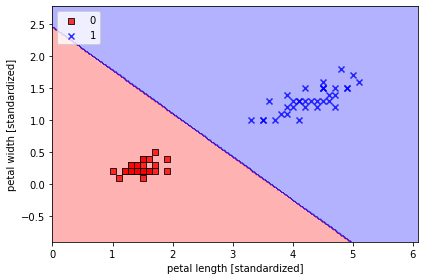

In [15]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()

## Training a logistic regression model with scikit-learn

### Exercise: Use the logistic regression model in scikit-learn to train the Iris date set. Print out the precision, acuracy and recall score on the test dateset. And plot the decision region.  

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=1, multi_class='ovr')
lr.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [17]:
y_test_pred = lr.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_test_pred).sum())

Misclassified samples: 1


In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[15,  0,  0],
       [ 0, 14,  1],
       [ 0,  0, 15]])

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy score: ", accuracy_score(y_test, y_test_pred))
print("Precision score: ", precision_score(y_test, y_test_pred, average=None))
print("Recall score: ", recall_score(y_test, y_test_pred, average=None))

Accuracy score:  0.9777777777777777
Precision score:  [1.     1.     0.9375]
Recall score:  [1.         0.93333333 1.        ]


In [20]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

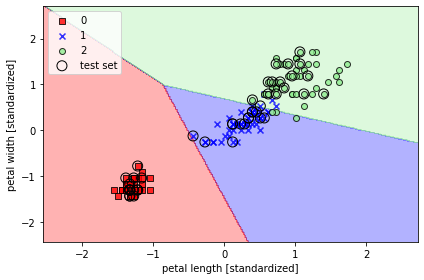

In [21]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

In [22]:
#print out the probability of prediction for the first three test samples. 
lr.predict_proba(X_test_std[:3, :])

array([[4.34030239e-04, 2.40177991e-01, 7.59387979e-01],
       [7.98497856e-01, 2.01272608e-01, 2.29535868e-04],
       [8.15957089e-01, 1.83932672e-01, 1.10238778e-04]])

In [23]:
#sum up the probability of all outcomes for each test sample
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)
#adding three numbers together on each row

array([1., 1., 1.])

In [24]:
#Use argmax to find the max output for each test sample
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [25]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

## Tackling overfitting via regularization

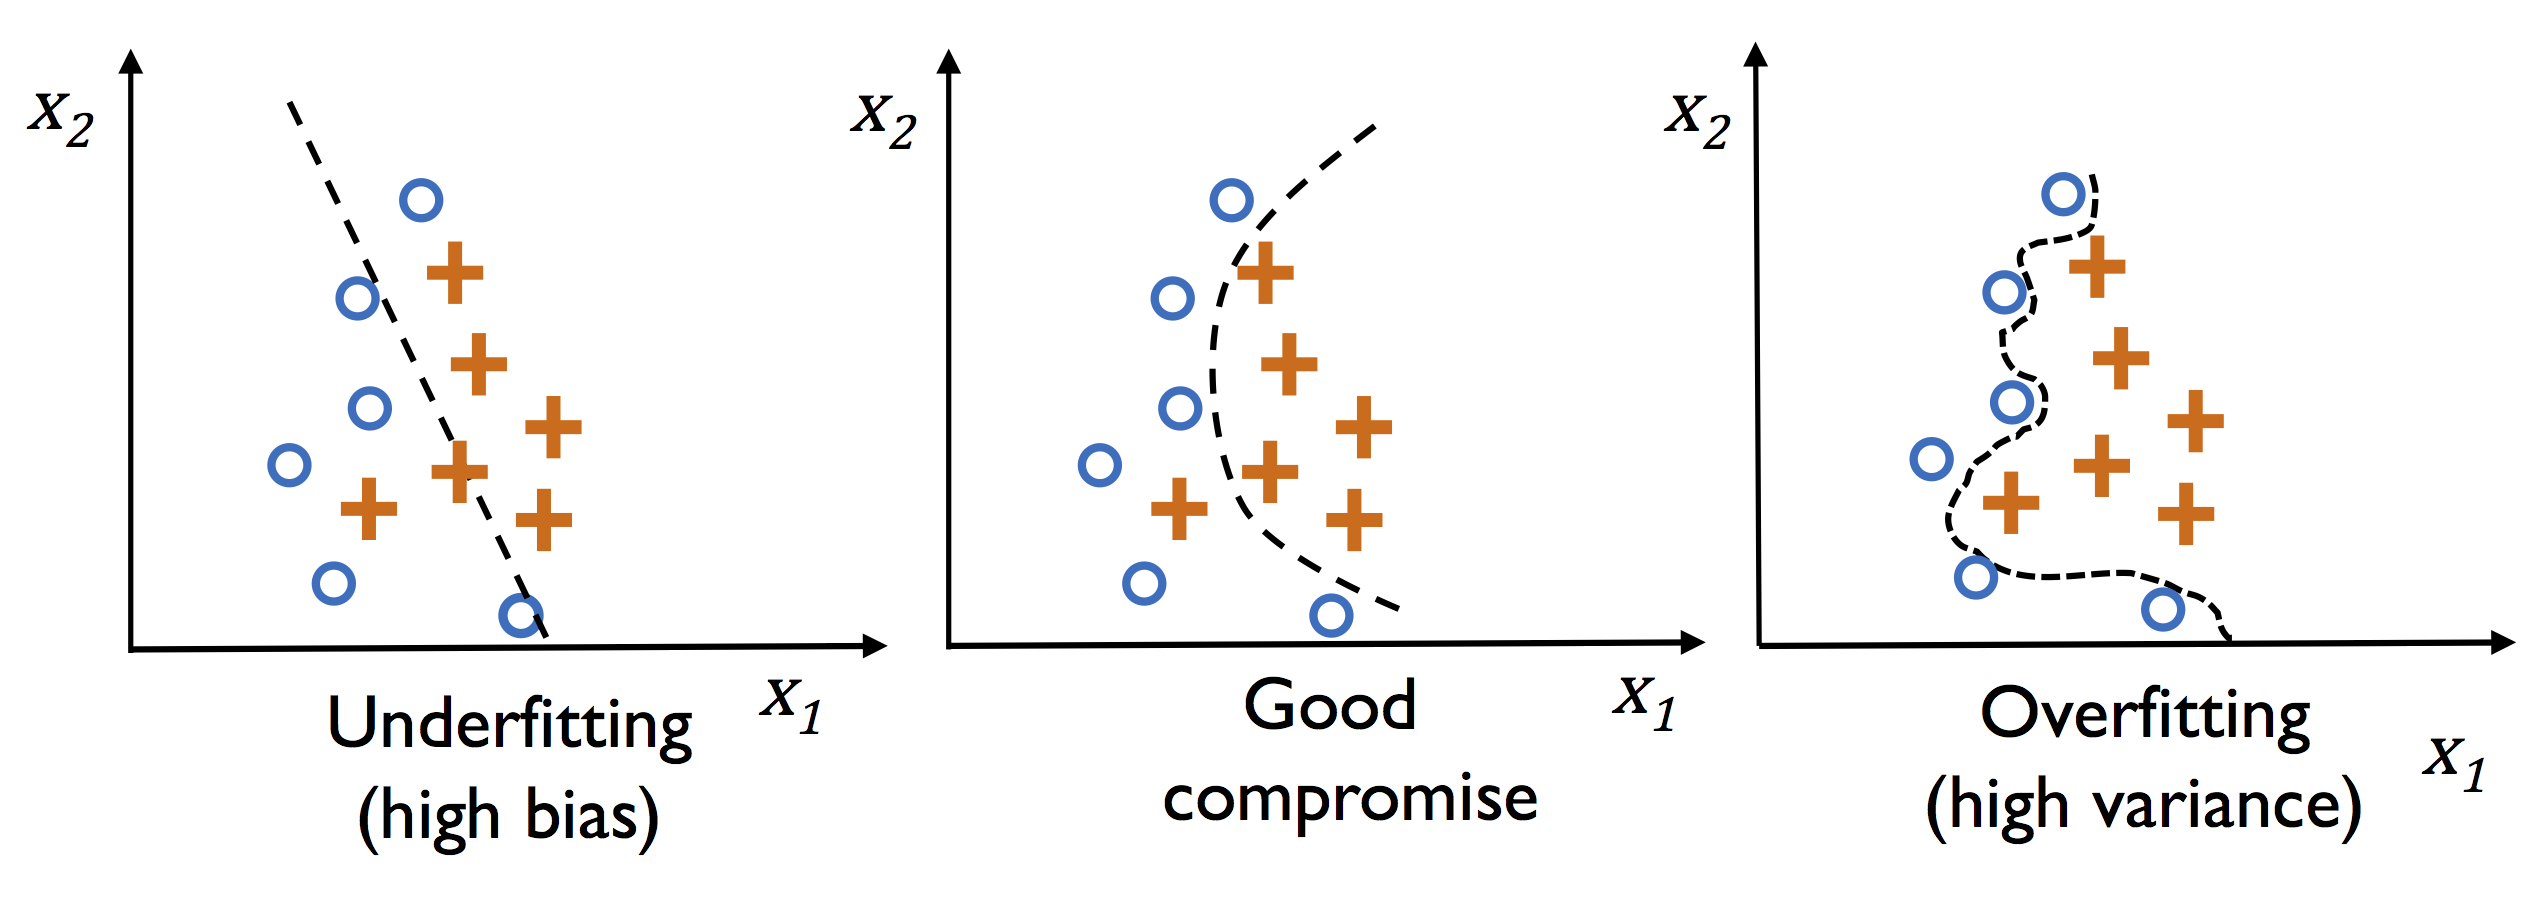

In [26]:
Image(filename='images/03_07.png', width=700) 

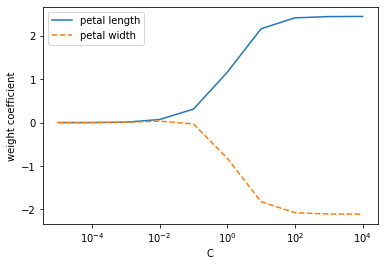

In [27]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, solver='lbfgs', multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()